In [10]:
import os
import cv2
from Astar import get_AStarPlanner
import apriltag
import numpy as np
from utils import *
from PIL import Image
import matplotlib.pyplot as plt

sh: ./stop_sys_ttyPS0.sh: No such file or directory


In [2]:
# 更新img图像的函数
def updateImage():
    orig_img_path = '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'
    ! fswebcam  --no-banner --save {orig_img_path} -d /dev/video0 2
    img = Image.open(orig_img_path)
    return img

In [3]:
# function 1 计算Y方向的机器人世界坐标y_rob

def XY_Robot():
    # 实例化检测器并检测Apriltag
    img = updateImage()
    img = np.array(img)
#     img = cv2.imread('1.jpg')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    options = apriltag.DetectorOptions(families='tag36h11',)
    detector = apriltag.Detector(options)
    tags = detector.detect(gray)
    tags_ids = [tag.tag_id for tag in tags]
#     print(tags)
    cnt = 0
    while len(tags) == 0 and cnt < 5:
        img = updateImage()
        img = np.array(img)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        tags = detector.detect(gray)
        cnt += 1
        if cnt == 5:
            run_action('turn003L')
            wait_req()
            cnt = 0
    
        
#     print(tags)
    # 获取pos和corners的代码
    tag_positions = load_tag_pos() 

    # 获取pos和corners的代码
    tag_num = len(tags)
    for n, tag in enumerate(tags):
#         print("debug here::",tag.tag_id)
#         if tag.tag_id > 41:
#             continue
        # 使用tag.id访问坐标，tag_positions的定义见前面，pos的形状为[4, 3]，分别代表已知的四个顶角在空间中的x,y,z三个坐标分量
        pos = tag_positions[str(tag.tag_id)]
#         print(pos)
        # 四个顶角在图片中的像素位置(形状为[4, 2]，分别代表四个顶角的像素空间坐标) 
        corners = np.array(tag.corners)
#         print(corners)
    # 2D坐标
    ImgPoints = corners
    # 3D坐标
    WorldPoints = pos
    # 内参矩阵
    fx = 192.0513
    fy = 194.1294
    cx = 311.9018
    cy = 233.6934
    intrinsic_matrix =  np.array([[fx,0,cx],
                              [0,fy,cy],
                              [0,0,1]],dtype = np.float64)
    # 畸变系数
    distCoeffs = np.array([0.2683,-0.2053,0,0])
    # 求解R和T的值
    retval, R, T = cv2.solvePnP(WorldPoints,ImgPoints,intrinsic_matrix,distCoeffs)
    rotM = cv2.Rodrigues(R)[0]
    cameraPosition = -np.matrix(rotM).T * np.matrix(T)
    # R矩阵的第三行
    direction = np.matrix(rotM)[2]
    #
    # print("朝向::",direction)
    x_robot = cameraPosition[0]
    y_robot = cameraPosition[1]
    
    dirXY = direction[:,:2]
    normdir = dirXY / np.linalg.norm(dirXY)
    # 使用numpy.tolist()转化为int类型
    return y_robot.tolist()[0][0],x_robot.tolist()[0][0],normdir

In [17]:
# 写一个固定转角的函数
def rotate_to_balance(zero):
    '''
    input:
    zero,角度的基准
    output:
    None.将机器人转为X轴正方向
    '''
    _,_,dirs= XY_Robot()
    theta = angle(dirs)

    # 设置一个物理上的零点,可供机器人调参数
    distance = theta - zero
    if distance > 180:
        distance -= 360
    if distance < -180:
        distance += 360

    # 优化版了rotate函数,对于转弯过大的情况单独处理
    if abs(distance) > 90:
        print("distance is too large:let's turn a big angle!")
        if distance > 0:
            run_action('turn010L')
            wait_req()
            run_action('turn010L')
            wait_req()
        else:
            run_action('turn010R')
            wait_req()
            run_action('turn010R')
            wait_req()
    if abs(distance) > 30:
        print("distance is too large:let's turn a big angle!")
        if distance > 0:
            run_action('turn010L')
            wait_req()
        else:
            run_action('turn010R')
            wait_req()
    elif abs(distance) > 15:
        print("distance is too large:let's turn a big angle!")
        if distance > 0:
            run_action('turn005L')
            wait_req()
        else:
            run_action('turn005R')
            wait_req()

    # 设定阈值为5度
    while abs(distance) > 5:
        if distance > 0:
            run_action('turn001L')
        if distance < 0:
            run_action('turn001R')
        _,_,dirs= XY_Robot()
        theta = angle(dirs)
        distance = theta - zero
        print("Adjusting angle: theta=",theta)
        print("Target angle:",zero)

    # 最后再微调一下
    if distance > 0.5:
        run_action('turn001L')
    if distance < -0.5:
        run_action('turn001R')
    print("Adjusting angle completed! Theta=",theta)
    
    return 0

In [19]:
# 获得下一个点的二维坐标，并移动
def move_to_next(next_loction_X, next_loction_Y,threshold=10):
    Y,X,direction = XY_Robot()
    # 转向
    move_dir = np.array([[next_loction_X-X, next_loction_Y-Y]])
    distance = np.linalg.norm(move_dir)
    norm_move_dir = move_dir / np.linalg.norm(move_dir)
    print("norm_move_dir = ",norm_move_dir)

    while distance > threshold:
        # 确定目标角度
        target_theta = angle(norm_move_dir)
        print('目标角度是：',target_theta)
        print('目标位置是:',next_loction_X, next_loction_Y)
        rotate_to_balance(target_theta)
        print('已调节至目标角度,前进！！！')
        wait_req()
        run_action('fastForward03')
        wait_req()
        Y,X,direction = XY_Robot()
        print('现在位置是:',X, Y)
        move_dir = np.array([[next_loction_X-X, next_loction_Y-Y]])
        distance = np.linalg.norm(move_dir)
        norm_move_dir = move_dir / np.linalg.norm(move_dir)
        print("norm_move_dir = ",norm_move_dir)
    return 0

In [ ]:
Y,X,direction = XY_Robot()
print("Robot的X坐标为:",X)
print("Robot的Y坐标为:",Y)
print("朝向为:",direction)
theta = angle(direction)
print("角度为:",theta)

In [ ]:
next_loction_X,next_loction_Y = 150,200
print('现在的X,Y = ',X,Y)
move_dir = np.array([[next_loction_X-X, next_loction_Y-Y]])
distance = np.linalg.norm(move_dir)
norm_move_dir = move_dir / np.linalg.norm(move_dir)
print("norm_move_dir = ",norm_move_dir)
target_theta = angle(norm_move_dir)
print('target theta = ',target_theta)

In [ ]:
run_action('fastForward03')

In [ ]:
a_star = get_AStarPlanner(grid_size=8)
sx = 15
sy = 15
tx = 170
ty = 200
rx, ry = a_star.planning(sx, sy, tx, ty)
plt.plot(sy, sx, "og")
plt.plot(ty, tx, "xb")
plt.plot(ry, rx, "-r")
print(rx,ry)

In [ ]:
def refine(x,y,dir):
    '''
    用于柱子前方调节位置和法向,建议只调节X或Y
    '''
    return 0


In [ ]:
def rush(pillar):
    return 0


def left():
    return 0

In [ ]:
from sift import judge
import random
# 开头识别一次,确定是什么类别
def recognize(x,y,dir,refineXYD = True):
    '''
    函数需要考虑两个用的地方,因为开头要识别助教的目标板,后来还要识别具体的柱子侧面,都要考虑到
    '''
    # 获取头部摄像头的图像
    img = updateImage()
    img = np.array(img)
    for i in range(1,7):
        target_img = cv2.imread("flowers/%s.jpg"%i,1)
        if judge(img1=img,img2=target_img,threshold=10)==True:
            # 如果满足匹配,返回类别序号1~6
            print("识别成功!类别为:%s"%i)
            return i
    # 没有匹配到,可能是朝向不准的问题,再重定向一次柱子前面
    if refineXYD:
        refine(x,y,dir) # 重定向XY和direction的函数
        img = updateImage()
        img = np.array(img)
        for i in range(1,7):
            target_img = cv2.imread("flowers/%s.jpg"%i,1)
            if judge(img1=img,img2=target_img,threshold=10)==True:
                # 如果满足匹配,返回类别序号1~6
                print("识别成功!类别为:%s"%i)
                return i
    return random.randint(1,7)

min_x: 0
min_y: 0
max_x: 294
max_y: 294
x_width: 10
y_width: 10
Find goal
line! [30, 30, 30, 30] [90, 120, 150, 180]
Find goal
line! [30, 60, 90, 120, 150, 180] [180, 210, 240, 240, 240, 270]
RX =  [30, 30, 30, 60, 90, 120, 150, 180] RY =  [120, 150, 180, 210, 240, 240, 240, 270] Mask =  [0, 0, 1, 0, 0, 0, 0, 1]


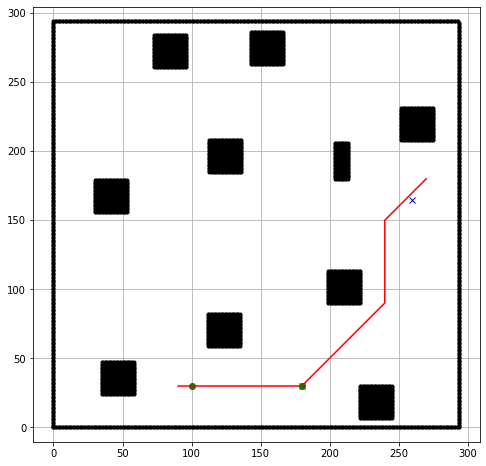

In [14]:
grid_size = 30 # cm
a_star = get_AStarPlanner(grid_size=grid_size)
points = [[30,100], [30,180], [165,260]]
RX = []
RY = []
Mask = []
for i in range(len(points)-1):
    start, goal = points[i], points[i+1]
    rx, ry = a_star.planning(start[0], start[1], goal[0], goal[1])
    print('line!',rx, ry)
    plt.plot(start[1], start[0], "og")
    plt.plot(goal[1], goal[0], "xb")
    plt.plot(ry, rx, "-r")
    RX.extend(rx[1:])
    RY.extend(ry[1:])
    mask = [0]*(len(rx)-1)
    mask[len(mask)-1] = 1
    Mask.extend(mask)
    
print("RX = ",RX,"RY = ",RY,"Mask = ",Mask)

In [10]:
def Go(sx,sy,tx,ty,pillars,target_flower_id,plan = True):
    """
    总函数
    input:输入
    sx:起点x坐标
    sy:起点y坐标
    tx:终点x坐标
    ty:终点y坐标
    pillars:需要识别的多个个柱子的信息:柱子正前方(x,y)和法向
    建议最多按三个按钮即可
    middle:中间变量
    Mask:长度和Rx,Ry相同,01列表,标记是否为柱子目标点
    RX,RY:规划路径列表
    """
    Y,X,direction = XY_Robot()
    a_star = get_AStarPlanner(grid_size=30)
    # case 1~4 判断
    RX = []
    RY = []
    Mask = []
    if plan == True:
        # 如果使用规划方式计算路径,rx,ry由Astar算法生成
        points = [i[0] for i in pillars]
        for i in range(len(points)-1):
            start, goal = points[i], points[i+1]
            rx, ry = a_star.planning(start[0], start[1], goal[0], goal[1])
            print('line!',rx, ry)
            RX.extend(rx[1:])
            RY.extend(ry[1:])
            mask = [0]*len(rx)-1
            mask[len(mask)-1] = 1
            Mask.extend(mask)
    else:
        Rx, Ry = "打表所得X","打表所得Y"
        Mask = "手动定义的mask"
    # 开始行走:
    for i in range(len(Mask)):
        move_to_next(RX[i],RY[i])
        flag = Mask[i] # 是否中断找柱面
        cnt = 0
        if flag == True:
            # 中断找柱面
            refine(x=pillars[cnt][0][0],y=pillars[cnt][0][1],dir=pillars[cnt][1])
            if recognize(x=pillars[cnt][0][0],y=pillars[cnt][0][1],dir=pillars[cnt][1],refineXYD=True) == target_flower_id:
                # 冲向柱面
                rush(pillars[cnt])
                #全身而退
                left() # 退几步
                move_to_next(RX[i],RY[i]) # 回到原来位置
            # 如果不是柱面目标,正常行走即可
        cnt += 1
    return 0

In [ ]:
# test:

XY = [[230,120], [230,170], [180,170], [130,170], [80,170], [30,170], [20, 180]]
for xy in XY:
    move_to_next(xy[0],xy[1])


In [ ]:
# case 1:
# 起点:[280, 120] 终点:[20, 180]  
# 具体过程点：[280,116], [280,124], [230,120], [230,170], [180,170], [130,170], [80,170], [30,170], [20, 180]

# 距离40cm进行冲撞，中间柱子面点:( , ),( , )

# TODO:
# 1.从起点出发依次到达中间柱子面点前方,进行识别算法,如果正确,调用rush()函数按按钮
# 2.退回合适位置,开始规划到终点路线
# 3.到达终点,再调研rush()函数按按钮:或者前面按了则不按

In [ ]:
# case 2:
# 起点:[20,86] 终点:[165,260] 
# 具体过程点：[20,86], [20,130], [20,180], [60,180], [60,220], [60,260], [115,260], [165,260]
# 中间柱子面点:( , ),( , )


# TODO:
# 1.从起点出发依次到达中间柱子面点前方,进行识别算法,如果正确,调用rush()函数按按钮
# 2.退回合适位置,开始规划到终点路线
# 3.到达终点,再调研rush()函数按按钮:或者前面按了则不按

In [ ]:
# case 3:
# 起点:( , ) 终点:( , ) 中间柱子面点:( , ),( , )


# TODO:
# 1.从起点出发依次到达中间柱子面点前方,进行识别算法,如果正确,调用rush()函数按按钮
# 2.退回合适位置,开始规划到终点路线
# 3.到达终点,再调研rush()函数按按钮:或者前面按了则不按

In [ ]:
# case 4:
# 起点:( , ) 终点:( , ) 中间柱子面点:( , ),( , )
# TODO:
# 1.从起点出发依次到达中间柱子面点前方,进行识别算法,如果正确,调用rush()函数按按钮
# 2.退回合适位置,开始规划到终点路线
# 3.到达终点,再调研rush()函数按按钮:或者前面按了则不按
